In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping
import tqdm
import yfinance as yf
import yahoo_fin.options as ops
import cmath

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm
import stochastic_processes as stch

In [3]:
expiration_dates = ops.get_expiration_dates("aapl")

In [4]:
expiration_dates

['April 8, 2022',
 'April 14, 2022',
 'April 22, 2022',
 'April 29, 2022',
 'May 6, 2022',
 'May 20, 2022',
 'June 17, 2022',
 'July 15, 2022',
 'August 19, 2022',
 'September 16, 2022',
 'October 21, 2022',
 'November 18, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023',
 'September 15, 2023',
 'January 19, 2024',
 'June 21, 2024']

In [5]:
s0_apple = 150.62 #15.03.2022

In [41]:
apple_option_calls = ops.get_puts("AAPL", expiration_dates[0])

In [42]:
apple_option_calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL220408P00100000,2022-03-28 9:35AM EDT,100.0,0.01,0.0,0.01,0.0,-,20,184,125.00%
1,AAPL220408P00105000,2022-03-28 11:29AM EDT,105.0,0.01,0.0,0.01,0.0,-,20,178,115.63%
2,AAPL220408P00110000,2022-03-31 1:19PM EDT,110.0,0.01,0.0,0.01,0.0,-,5,362,106.25%
3,AAPL220408P00115000,2022-04-01 1:21PM EDT,115.0,0.01,0.0,0.01,0.0,-,5,859,96.88%
4,AAPL220408P00120000,2022-04-01 9:54AM EDT,120.0,0.01,0.0,0.00,0.0,-,3,2141,50.00%


In [43]:
# apple_option_calls.to_csv('apple_option_call_april_01_2022.csv')

In [44]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [45]:
apple_spread = apple_option_calls.loc[:, 'Ask'] - apple_option_calls.loc[:, 'Bid']

In [46]:
from datetime import datetime

In [47]:
expr_date = datetime.strptime(expiration_dates[1], '%B %d, %Y')
expr_date

datetime.datetime(2022, 4, 14, 0, 0)

In [48]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 4, 2, 19, 50, 34, 595165)

In [49]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.030116358658453114

In [50]:
N = 500
T = maturity
r = 0.05
rho1 = 0.01

# type_option = 'c'
type_option = 'p'

In [51]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0, spread):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [52]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.1), (0.1, 4), (0.2, 1), (0.01, 0.5), (0.01, 1), (-0.9, 0.9))

# P0T = lambda T: np.exp(0.0012*T+0.0007) 
s0 = 174.62

# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# T = 5/365.25
# referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
# marketPrice = P0T(T)* exm.BS_Call_Option_Price('c', s0 / P0T(T), K, referenceIV, T, 0)


# params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
#                              bounds=bounds, tol=1e-4, options={"maxiter": 1000})

K = apple_strikes
marketPrice = apple_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0, apple_spread),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 0.46505811947163117
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.19044657e-02,  2.59926025e-02, -4.23285016e-02,  2.93861047e-01,
        2.30765890e+00, -7.16154910e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 10
     njev: 20
   status: 0
  success: True
        x: array([0.00601338, 0.1       , 1.        , 0.01      , 0.01      ,
       0.84658583])

In [53]:
np.sqrt(params_heston_COS.fun)

0.681951698781982

In [54]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [55]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

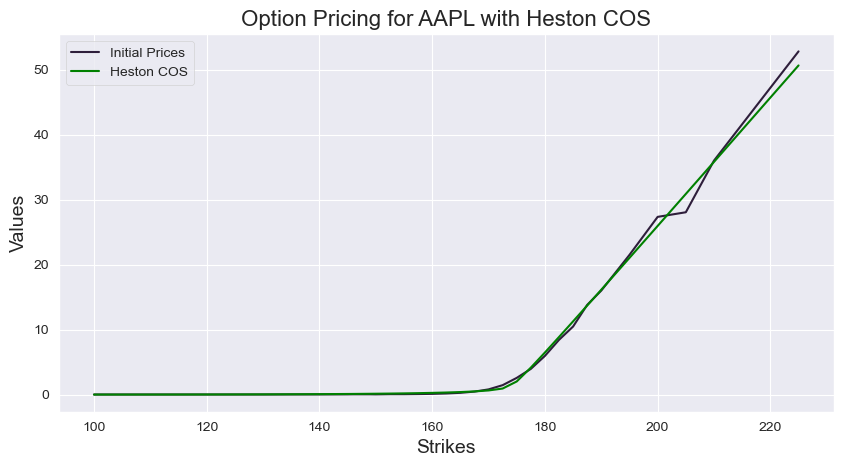

In [56]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [115]:
def calibrationBates_SIR_SC(CP, rho0, xip, muJ, sigmaJ, r0, K, marketPrice, s0, T, P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0]
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[10], x[3], x[4], x[11], x[5], x[6], x[7], x[8], xip, muJ,
                               sigmaJ, x[9], x[13], x[12], K, marketPrice, s0, P0T)

    #[k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0]
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.05, 0.4, 0.5, -0.7, 0.001])
#     pars  = minimize(f_obj, initial, method='nelder-mead', options = {'xtol': 1e-05, 'disp': False,'maxiter':1000})
    
    xmin = [0.001, 0.0001, 0.0001, 0.0005, 0.001, 0.0001, 0.0005, -0.8, -0.8, 0.0001, 0.0001, 0.4, -0.98, -0.1]
#     xmax = [2, 0.3, 0.4, 0.3, 0.4, 0.4, 0.2, 0.8, 0.8, 0.3, 0.99, 0.99]  
    xmax = [5, 0.7, 0.8, 0.7, 0.7, 0.4, 0.25, 0.9, 0.9, 0.3, 4, 5, 0.98, 0.5] 
    
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

#     # Global search
    pars = basinhopping(f_obj, initial, niter=1, minimizer_kwargs=minimizer_kwargs)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    kr_est = pars.x[10]
    krho_est = pars.x[11]
    rho0 = pars.x[12]
    r0 = pars.x[13]

    print(f'Initial guess: {pars.x}', pars.fun)

#     Use global parameters in the local search
    initial = [k_est, gamma_est, vb_est, gammar_est, mur_est, murho_est, sigmarho_est, rho4_est, rho5_est, v0_est, kr_est, krho_est, rho0, r0] 
    
#     pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
    pars  = minimize(f_obj, x0=initial, method='nelder-mead', tol=1e-6, options = {'maxiter': 100, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    kr_est = pars.x[10]
    krho_est = pars.x[11]
    rho0 = pars.x[12]
    r0 = pars.x[13]
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est, "murho":murho_est, \
                   "sigmarho":sigmarho_est, "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0, "r0": r0, 'ErrorFinal':pars.fun}
    return parmCalibr

In [116]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0, P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L, P0T(T))

    errorVector = np.mean((valCOS - marketPrice)**2)
#     errorVector = valCOS - marketPrice
    value = errorVector
#     value = np.linalg.norm(errorVector)

    return value

In [117]:
T = maturity
tau = T
s0 = 174.62

xip = 0.005
muJ = 0
sigmaJ = 0.1


# r0 = 0.005
# rho0 = -0.7
# CP  = 'c'

type_option = 'p'

P0T = lambda T: np.exp(0.0005*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)

# dt = 0.01    
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 =abs(f0T(0.001))

# P0T = lambda T: np.exp(0.0012*T+0.0007)
    
#     T = 0.5
# referenceIV  = np.array([57.61, 22.95, 15.9])/100.0
    
#T = 1.0
# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# #T = 10.0
# # referenceIV = np.array([36.76, 29.18, 27.66])/100.0
# s0 = 150.62
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# # K = apple_strikes
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])


# marketPrice = P0T(T) * BS_Call_Put_Option_Price(OptionType.CALL, s0 / P0T(T),K,referenceIV,T,0.0)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, rho0, xip, muJ, sigmaJ, r0, K, marketPrice, s0, T, P0T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')

errorFinal = calibratedParms.get('ErrorFinal') 

Initial guess: [ 2.98553900e-02  7.00000000e-01  8.00000000e-01  7.00000000e-01
  9.54901987e-02  1.00000000e-04  2.50000000e-01 -5.06034825e-01
 -8.00000000e-01  9.96537205e-02  1.00000000e-04  4.00000000e-01
 -9.80000000e-01  5.00000000e-01] 254.37052059872863
 final_simplex: (array([[ 1.11465290e-02,  7.07546209e-01,  1.16101486e+00,
         4.56458682e-01,  1.22270504e-01,  3.03737651e-05,
         2.28938678e-01, -3.28451134e-01, -4.07552015e-01,
         1.12488213e-01,  1.76593751e-04,  4.20755529e-01,
        -1.03444492e+00,  1.39664854e+00],
       [ 1.02540186e-02,  7.38912110e-01,  1.18864923e+00,
         4.49455376e-01,  1.15675390e-01,  2.99843333e-05,
         2.35375768e-01, -3.22066044e-01, -3.39350993e-01,
         1.08531453e-01,  1.80689780e-04,  4.21053203e-01,
        -1.03299742e+00,  1.39919004e+00],
       [ 9.48516716e-03,  7.13132720e-01,  1.17758331e+00,
         4.74876562e-01,  1.14097568e-01,  2.63695777e-05,
         2.41669507e-01, -2.93041532e-01, -3

In [118]:
np.sqrt(errorFinal)

14.94494439206951

In [119]:
round(errorFinal, 9)

223.351362882

In [120]:
cf(np.array([1, 2, 3]).reshape([3,1]))

array([[0.91026506+0.01488601j],
       [0.91201092+0.02768071j],
       [0.90963548+0.03971023j]])

In [121]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L, P0T(T))

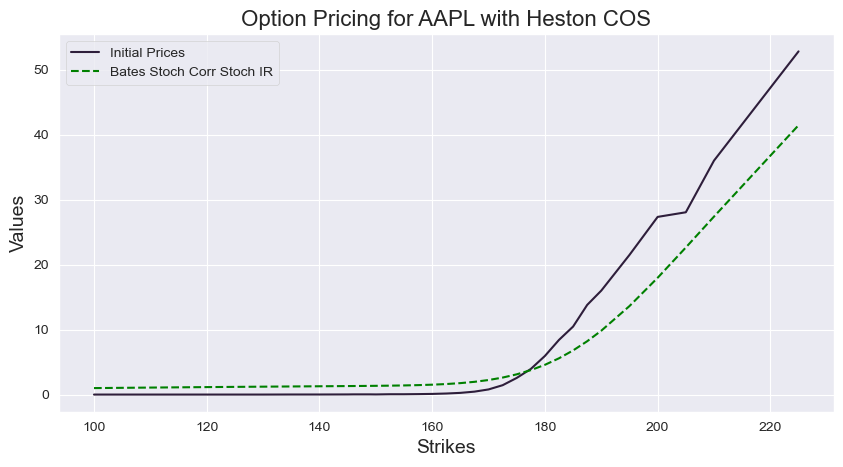

In [122]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [ ]:
print(f'r0: {r0}, v0: {v0}, rho0: {rho0}')

<ipython-input-19-faece5d2e64d>:159: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i = np.complex(0.0,1.0)


                        fun: 2.031867633290543e-06
 lowest_optimization_result:       fun: 2.031867633290543e-06
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.17752925,  0.52228015, -2.71873853, 13.94900128])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 420
      nit: 39
     njev: 84
   status: 0
  success: True
        x: array([ 0.70704033,  0.08640816, -0.75037272,  0.09242866])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 765
                        nit: 1
                       njev: 153
                          x: array([ 0.70704033,  0.08640816, -0.75037272,  0.09242866])
Optimal parameters for H1-HW are: gamma = 0.707, vBar = 0.086, Rxv = -0.750, v0 = 0.092
Final error for H1HW=2e-07


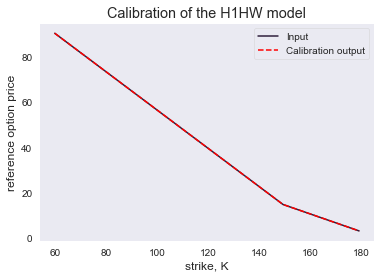

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize

i   = complex(0.0,1.0)

# Time step 
dt = 0.0001

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd_StochIR(cf,CP,S0,tau,K,N,L,P0T):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
    # P0T  - Zero-coupon bond for maturity T.

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(OptionType.PUT,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = K * np.real(mat.dot(temp))     
    
    # We use the put-call parity for call options

    if CP == OptionType.CALL:
        value = value + S0 - K * P0T
        
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def BS_Call_Put_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    if sigma is list:
        sigma = np.array(sigma).reshape([len(sigma),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatilityBlack76(CP,marketPrice,K,T,S_0):

    # To determine initial volatility we define a grid for sigma
    # and interpolate on the inverse function

    sigmaGrid = np.linspace(0.0,5.0,5000)
    optPriceGrid = BS_Call_Put_Option_Price(CP,S_0,K,sigmaGrid,T,0.0)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    print("Strike = {0}".format(K))
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use already determined input for the local-search (final tuning)

    func = lambda sigma: np.power(BS_Call_Put_Option_Price(CP,S_0,K,sigma,T,0.0) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    print("Final volatility = {0}".format(impliedVol))
    if impliedVol > 2.0:
        impliedVol = 0.0
    return impliedVol




def meanSqrtV_3(kappa,v0,vbar,gamma):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t)))
    kappaBar = lambda t: 4.0*kappa*v0*np.exp(-kappa*t)/(gamma*gamma*(1.0-np.exp(-kappa*t)))
    temp1 = lambda t: np.sqrt(2.0*c(t))* sp.gamma((1.0+delta)/2.0)/sp.gamma(delta/2.0)*sp.hyp1f1(-0.5,delta/2.0,-kappaBar(t)/2.0)
    return temp1

def C_H1HW(u,tau,lambd):
    i = complex(0.0,1.0)
    C = (i*u - 1.0)/lambd * (1-np.exp(-lambd*tau))
    return C

def D_H1HW(u,tau,kappa,gamma,rhoxv):
    i = np.complex(0.0,1.0)
    
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    D  = (1.0-np.exp(-D1*tau))/(gamma*gamma*(1.0-g*np.exp(-D1*tau)))\
        *(kappa-gamma*rhoxv*i*u-D1)
    return D
    
def A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr):
    i  = complex(0.0,1.0)
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    
    # Function theta(t)

    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))  

    # Integration within the function I_1

    N  = 500
    z  = np.linspace(0,tau-1e-10,N)
    f1 = (1.0-np.exp(-lambd*z))*theta(tau-z)
    value1 = integrate.trapz(f1,z)
    
    # Note that I_1_adj also allows time-dependent theta 
    # Therefore it is not exactly the same as in the book

    I_1_adj = (i*u-1.0) * value1
    I_2     = tau/(gamma**2.0) *(kappa-gamma*rhoxv*i*u-D1) - 2.0/(gamma**2.0)*np.log((1.0-g*np.exp(-D1*tau))/(1.0-g))
    I_3     = 1.0/(2.0*np.power(lambd,3.0))* np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    
    meanSqrtV = meanSqrtV_3(kappa,v0,vbar,gamma)
    f2        = meanSqrtV(tau-z)*(1.0-np.exp(-lambd*z))
    value2    = integrate.trapz(f2,z)
    I_4       = -1.0/lambd * (i*u+u**2.0)*value2
    
    return I_1_adj + kappa*vbar*I_2 + 0.5*eta**2.0*I_3+eta*rhoxr*I_4

def ChFH1HWModel(P0T,lambd,eta,tau,kappa,gamma,vbar,v0,rhoxv, rhoxr):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    r0 =f0T(0.00001)
    C = lambda u: C_H1HW(u,tau,lambd)
    D = lambda u: D_H1HW(u,tau,kappa,gamma,rhoxv)
    A = lambda u: A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr)
    cf = lambda u: np.exp(A(u) + C(u)*r0 + D(u)*v0 )
    return cf


def calibrationH1HW_Global(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0]
    f_obj = lambda x: TargetValH1HW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],eta,lambd,K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05])
    
    # The bounds

    xmin = [0.1, 0.001,-0.99, 0.001]
    xmax = [0.8,  0.4,  -0.3, 0.4]    
    
    # Rewrite the bounds as required by L-BFGS-B

    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    # Use L-BFGS-B method because the problem is smooth and bounded

    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

    # Global search

    pars = optimize.basinhopping(f_obj, initial,niter=1, minimizer_kwargs=minimizer_kwargs)
    
    print(pars)
    
    # Use global parameters in the local search

    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    initial = [gamma_est,vBar_est,Rxv_est,v0_est]    
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':200})
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est,'ErrorFinal':pars.fun}
    return parmCalibr

# Calibration of the Heston Hull-White model 

def calibrationH1HW(CP,kappa,Rxr,eta,lambd,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0]
    f_obj = lambda x: TargetValH1HW(CP,kappa,x[0],x[1],Rxr,x[2],x[3],eta,lambd,K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05])
    pars  = minimize(f_obj,initial,method='nelder-mead', options = \
                     {'xtol': 1e-05, 'disp': False,'maxiter':100})
    print(pars)
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est,'ErrorFinal':pars.fun}
    return parmCalibr

def TargetValH1HW(CP,kappa,gamma,vBar,Rxr,Rxv,v0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 2000
    L = 15  
    cf = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0, Rxv, Rxr)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = valCOS - marketPrice
    
    # Target value is a norm of the error vector

    value       = np.linalg.norm(errorVector)   
#     print("Total Error = {0}".format(value))
    return value

def mainCalculation():
    CP  = OptionType.CALL  
        
    # HW model parameter settings

    lambd = 0.01
    eta   = 0.01
    S0    = 150      
   
    # Fixed SZHW / H1-HW model parameters

    kappa =  0.5
    Rxr   =  0.3
      
    # We define a ZCB curve (obtained from the market)
    # This curve is based on the estimation to real market data

#     P0T = lambda T: np.exp(0.0012*T+0.0007) 
       
    # Settings for the COS method

    N = 2000
    L = 15  
    
    ################## Here we define market call option prices #################
    
    T = 1
    referenceIV  = np.array([57.61, 22.95, 15.9])/100.0
    
    #T = 1.0
    #referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
    #T = 10.0
    #referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
    # Strike range
    P0T = lambda T: np.exp(0.005*T)
    
    

    frwd = S0/P0T(T)
#     K = [0.4*frwd, frwd, 1.2*frwd]
#     K = apple_strikes

    referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
    K = [0.4*frwd, frwd, 1.2*frwd]
    K = np.array(K).reshape([len(K),1])
    
    
    referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
    referencePrice = P0T(T)* BS_Call_Put_Option_Price(CP,S0 / P0T(T),K,referenceIV,T,0.0)
#     referencePrice = apple_market_price

    plt.figure(2)
    plt.title('Calibration of the H1HW model')
    plt.plot(K,referencePrice)
    plt.xlabel('strike, K')
    plt.ylabel('reference option price')
    plt.grid()
    
    calibratedParms =  calibrationH1HW_Global(CP,kappa,Rxr,eta,lambd,K,referencePrice,S0,T,P0T)
    
    gamma = calibratedParms.get('gamma')
    vBar  = calibratedParms.get('vBar')
    Rxv   = calibratedParms.get('Rxv')
    v0    = calibratedParms.get('v0')
    errorH1HW = calibratedParms.get('ErrorFinal')   
    
    cf2 = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0,Rxv, Rxr)
    valCOS_H1HW = CallPutOptionPriceCOSMthd_StochIR(cf2, CP, S0, T, K, N, L,P0T(T))
    
    plt.plot(K,valCOS_H1HW,'--r')
    plt.legend(['Input','Calibration output'])
    
    
    print("Optimal parameters for H1-HW are: gamma = {0:.3f}, vBar = {1:.3f}, Rxv = {2:.3f}, v0 = {3:.3f}".format(gamma,vBar,Rxv,v0))
    print("=======================================================================")
    print('Final error for H1HW={0}'.format(round(errorH1HW, 9)))
    
    # Plot implied volatilities for both models    

#     IVH1HW =np.zeros([len(K),1])
#     IVSZHW =np.zeros([len(K),1])
#     IVMarket =np.zeros([len(K),1])
#     for (idx,k) in enumerate(K):
#         IVMarket[idx] = ImpliedVolatilityBlack76(CP,referencePrice[idx]/P0T(T),k,T,S0/P0T(T))*100.0
#         IVH1HW[idx] = ImpliedVolatilityBlack76(CP,valCOS_H1HW[idx]/P0T(T),k,T,S0/P0T(T))*100.0
#         IVSZHW[idx] = ImpliedVolatilityBlack76(CP,valCOS_SZHW[idx]/P0T(T),k,T,S0/P0T(T))*100.0
    
#     plt.figure(3)
#     plt.plot(K,IVMarket)
#     plt.plot(K,IVH1HW,'--r')
#     plt.plot(K,IVSZHW)
#     plt.grid()
#     plt.legend(['market','H1HW','SZHW'])
    
#     print('Market IV')
#     print(IVMarket)
#     print('H1HW IV')
#     print(IVH1HW)
#     print('SZHW IV')
#     print(IVSZHW)
    
mainCalculation()

In [2]:
import numpy as np

In [4]:
dt = 0.0001 
P0T = lambda T: np.exp(0.0012*T+0.0007) 
f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
f0T(0.00001)

-0.0011999999998231958

In [13]:
# v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2

def error_heston_stoch_corr_AES(x, prices, K, s0):
    paths = mcm.heston_stoch_corr_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
    price_calib = mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, T, r)
    
    return sum(((price_calib - prices)/apple_spread)**2)/len(prices)

In [565]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 5), (1, 5), (0.5, 1), (0.01, 5), (-0.9, 0.9), (3, 5), (0.1, 1), (0.01, 0.4), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, spread),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})
params_heston_AES

      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.14152285e+12,  1.70027185e+12,  1.76700558e+12,  3.11887014e+12,
        3.73929715e+12,  1.97235960e+12,  9.25205290e+11, -2.80021614e+12,
        2.34097609e+12])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 0.04,  2.  ,  0.5 ,  0.02, -0.8 ,  4.  ,  0.2 ,  0.4 ,  0.02])

In [547]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [548]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_apple, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [549]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:,-1], apple_strikes, T, r)

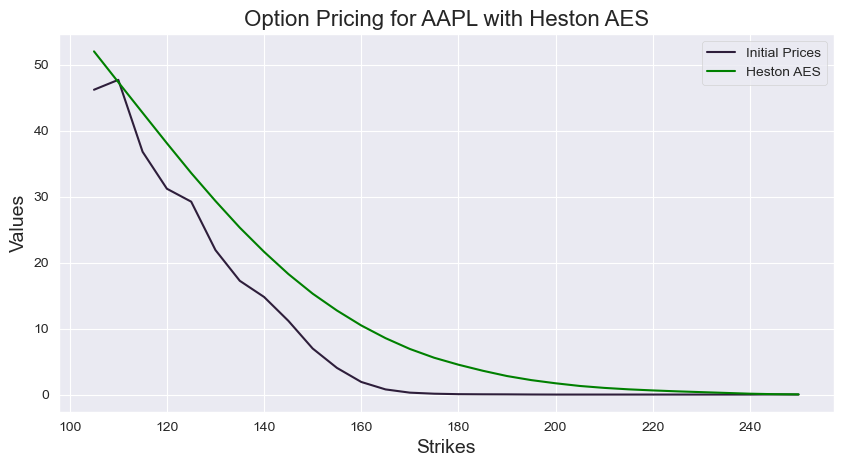

In [550]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for AAPL with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [409]:
tsla = ops.get_calls("TSLA", 'April 1, 2022')

In [410]:
# tsla.to_csv('tsla_option_call_april_01_2022.csv')

In [411]:
s0_tsla = 766.37 #15.03.2022

In [412]:
tsla_strikes = tsla.loc[:, 'Strike']
tsla_market_price = tsla.loc[:, 'Last Price']

In [423]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0, 1), (0.01, 0.1), (-0.9, 0.9), (3, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(tsla_market_price, tsla_strikes, s0_tsla), bounds=bounds, tol=1e-10, options={"maxiter": 2000})
params_heston_AES

/Users/kirillzakharov/Desktop/Stochastic Calculus/monte_carlo_methods.py:173: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1- (rho[:, t])**2 - ((rho2-rho1*rho[:, t])/np.sqrt(1-rho1**2))**2)*np.sqrt(V[:, t]) * np.sqrt(dt) * Zx[:, t]


      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.34896949e+12, -2.17063453e+12, -4.47419204e+12, -3.56736088e+12,
       -4.18361986e+12, -2.77998814e+12, -5.39473593e+12, -1.63114535e+12,
       -2.20910285e+12])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 0.04,  2.  ,  0.2 ,  0.02, -0.8 ,  4.  ,  0.2 ,  0.4 ,  0.02])

In [424]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [425]:
paths_heston_AES = mcm.heston_stoch_corr_AES(numberPaths, N, s0_tsla, v0, T, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]

In [426]:
option_heston_AES = mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:, -1], tsla_strikes, T, r)

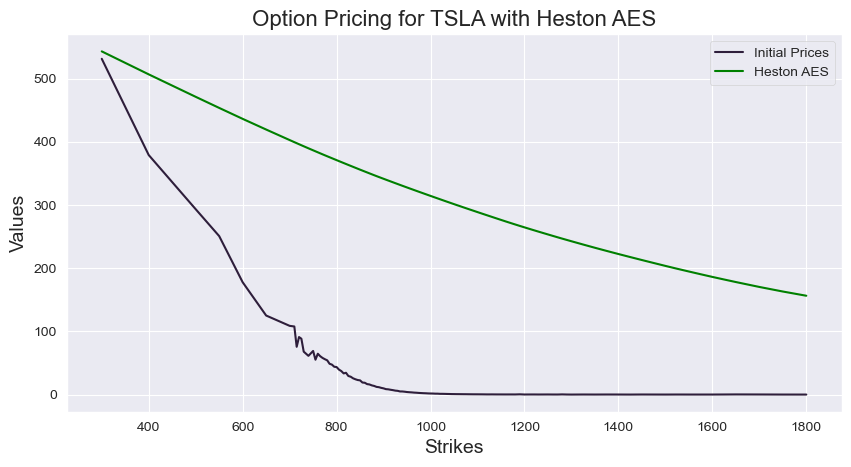

In [427]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(tsla_strikes, tsla_market_price, label='Initial Prices')
plt.plot(tsla_strikes, option_heston_AES, color='green', label='Heston AES')
        
plt.title('Option Pricing for TSLA with Heston AES', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [428]:
s0 = 100
sigma = 0.5
T = 20

In [429]:
process = stch.StochasticProcesses()
gbm = process.geometric_BM(T, s0, r, sigma, T)

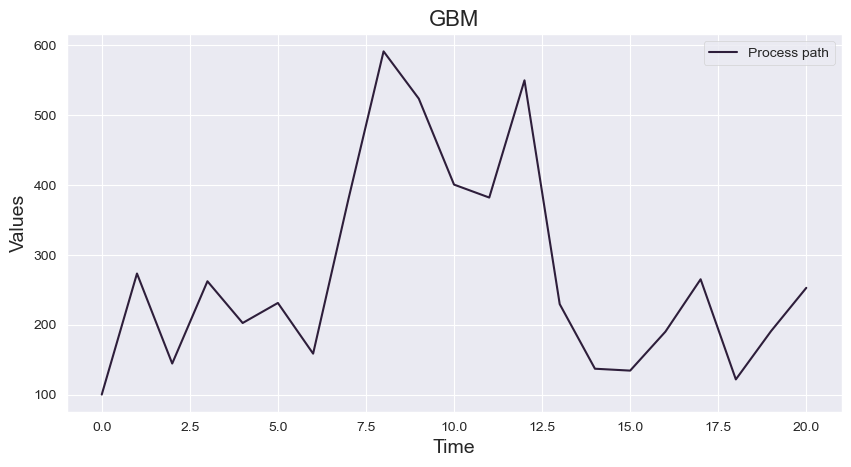

In [430]:
time = gbm[0]
process.plot_path(time, gbm[1], title='GBM')

### Black-Scholes

In [468]:
K1 = np.array([110])
# K1 = [110, 120, 125]
r = 0.05
s0 = 100
T = 20

N = T

In [469]:
options_BS_time = []

for t in range(T):
    options_BS_time.append(exm.BS_Call_Option_Price(type_option, gbm[1][t], K1, sigma, T-t, r))
    
options_BS_time = np.array(options_BS_time)

### Heston AES

In [487]:
# v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2

def error_heston_stoch_corr_AES(x, prices, K, s0, T):
#     paths = mcm.heston_stoch_corr_AES(numberPaths, N, s0, x[0], T, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
#     price_calib = mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, T, r)
    price_calib = []
    for t in range(1, T+1):
        paths = mcm.heston_stoch_corr_AES(numberPaths, t, s0, x[0], t, x[1], x[2], x[3], x[4], r, x[5], x[6], x[7], rho1, x[8])[1]
    
        price_calib.append(mcm.optionPriceMCGeneral(type_option, paths[:, -1], K, t, r))
    price_calib = np.array(price_calib)
#     print(price_calib)
    
    return np.mean((price_calib - prices)**2)

In [497]:
init_vals = [0.04, 2, 0.2, 0.02, -0.8, 4, 0.2, 0.4, 0.02]
bounds = ((0.01, 0.1), (0, 5), (0.2, 1), (0.01, 0.1), (-0.9, 0.9), (3, 5), (0.01, 1), (0.01, 0.5), (0.01, 0.08))

params_heston_AES = minimize(error_heston_stoch_corr_AES, x0=init_vals, args=(options_BS_time, K1, s0, T), bounds=bounds, tol=1e-5, options={"maxiter": 2000})
params_heston_AES

      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.69398370e+10, -2.79700959e+10,             nan,  1.91678080e+10,
       -1.74874569e+10,  1.13026234e+10, -9.09178910e+09, -2.97080936e+10,
       -4.82536373e+10])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 380
      nit: 2
     njev: 38
   status: 2
  success: False
        x: array([ 0.04000001,  2.00000021,  0.20000006,  0.02      , -0.80000001,
        4.00000008,  0.19999998,  0.39999998,  0.02      ])

In [490]:
v0, kappa, gamma, vbar, rho0, kp, mup, sigmap, rho2 = params_heston_AES.x

In [491]:
option_heston_AES = []

for t in range(T):
    paths_heston_AES = mcm.heston_stoch_corr_AES(500, N, s0, v0, t, kappa, gamma, vbar, rho0, r, kp, mup, sigmap, rho1, rho2)[1]
    option_heston_AES.append(mcm.optionPriceMCGeneral(type_option, paths_heston_AES[:, -1], [K1], t, r))
    
option_heston_AES = np.array(option_heston_AES).T[0]  

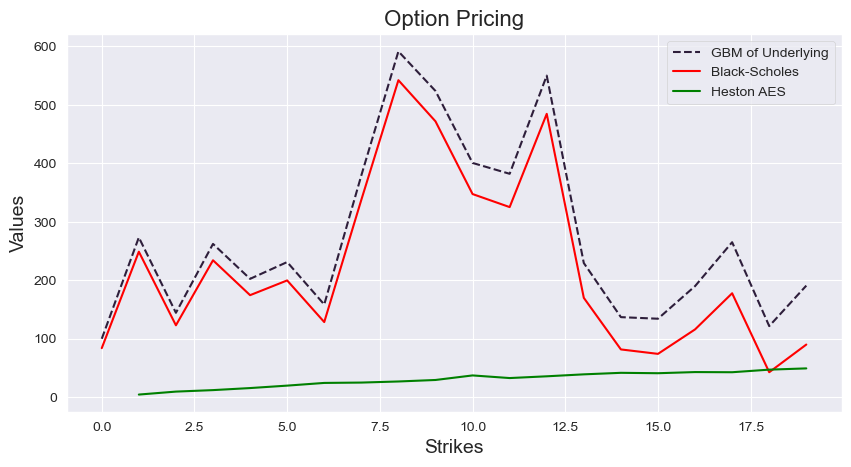

In [492]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(gbm[1][:-1], '--', label='GBM of Underlying')
plt.plot(options_BS_time, c='red', label='Black-Scholes')
plt.plot(option_heston_AES, c='green', label='Heston AES')
        
plt.title('Option Pricing', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [493]:
option_heston_AES

array([        nan,  4.62390236,  9.69188708, 12.23667668, 15.73569543,
       19.90756675, 24.52200305, 25.12859118, 26.99585068, 29.55637207,
       37.34396416, 32.84857732, 35.84513213, 39.19583837, 41.79514592,
       41.12057674, 43.08000651, 42.81058126, 47.22765408, 49.37531783])